<a href="https://colab.research.google.com/github/archie46/Deep-Learning-Lab/blob/main/Lab6Alternate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import sklearn.metrics as sk_metrics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/AML6/chest_xray

[Errno 2] No such file or directory: '/content/drive/MyDrive/AML6/chest_xray'
/content


In [ ]:
ls

chest_xray/  __MACOSX/  ROC.png  test/  train/  val/


In [ ]:
batch_size = 32
img_height = 256
img_width = 256

In [ ]:
train_ds=keras.utils.image_dataset_from_directory(
    directory='train',
    labels='inferred',
    label_mode='int',
   image_size=(img_height, img_width),
  batch_size=batch_size
)


val_ds=keras.utils.image_dataset_from_directory(
    directory='val',
    labels='inferred',
    label_mode='int',
   image_size=(img_height, img_width),
  batch_size=batch_size
)

test_ds=keras.utils.image_dataset_from_directory(
    directory='test',
    labels='inferred',
    label_mode='int',
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


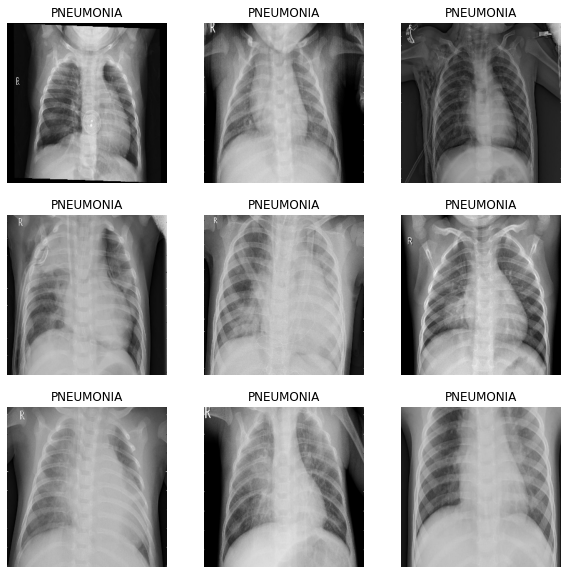

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 128)               33554560  
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
163/163 [==============================] - 408s 2s/step - loss: 1.1138 - accuracy: 0.8418 - val_loss: 0.5084 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 316s 2s/step - loss: 0.2870 - accuracy: 0.9162 - val_loss: 0.4440 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 321s 2s/step - loss: 0.1845 - accuracy: 0.9645 - val_loss: 0.3745 - val_accuracy: 0.8750
Epoch 4/10
163/163 [==============================] - 321s 2s/step - loss: 0.1511 - accuracy: 0.9741 - val_loss: 0.4448 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 330s 2s/step - loss: 0.1348 - accuracy: 0.9743 - val_loss: 0.3623 - val_accuracy: 0.8750
Epoch 6/10
163/163 [==============================] - 325s 2s/step - loss: 0.1177 - accuracy: 0.9768 - val_loss: 0.1961 - val_accuracy: 0.9375
Epoch 7/10
163/163 [==============================] - 320s 2s/step - loss: 0.1160 - accuracy: 0.9806 - val_loss: 0.5558 - val_accuracy: 0.7500

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

print('\nTest accuracy:', test_acc)

20/20 [==============================] - 103s 3s/step - loss: 2.0519 - accuracy: 0.6939

Test accuracy: 0.6939102411270142


In [ ]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(test_ds)

20/20 [==============================] - 33s 1s/step


In [ ]:
predictions = np.array(predictions)

In [ ]:
pred_score = []
pred_labels =[]
for i in range(len(predictions)):
  pred_score.append(np.max(predictions[i]))
  pred_labels.append(np.argmax(predictions[i]))
pred_score = np.array(pred_score)
pred_labels = np.array(pred_labels)

In [ ]:
test_labels = []
for _,labels in test_ds:
  for i in labels:
    test_labels.append(i)


In [ ]:
tf.print(len(test_labels))

624


In [ ]:
test_labels = np.array(test_labels)

In [ ]:
cm = sk_metrics.confusion_matrix(test_labels, pred_labels)
print("Confusion Matrix : \n",cm)

Confusion Matrix : 
 [[ 18 216]
 [ 27 363]]


In [ ]:
print("Sensitivity : ",cm[0][0]/(cm[0][0]+cm[1][0]))
print("Specifivity : ",cm[1][1]/(cm[1][1]+cm[0][1]))

Sensitivity :  0.4
Specifivity :  0.6269430051813472


In [ ]:
print(sk_metrics.classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.40      0.08      0.13       234
           1       0.63      0.93      0.75       390

    accuracy                           0.61       624
   macro avg       0.51      0.50      0.44       624
weighted avg       0.54      0.61      0.52       624



In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(test_labels,pred_score)
metrics.auc(fpr, tpr)

0.5281339031339032

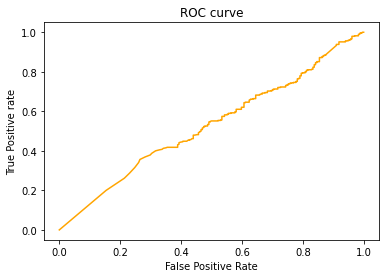

In [ ]:
plt.plot(fpr, tpr,color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.show()

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label= true_label[i]
  j = 0
  for images, labels in test_ds.take(1):
    while j != i:
      j += 1
    img = images[j]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img.numpy().astype("uint8"), cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

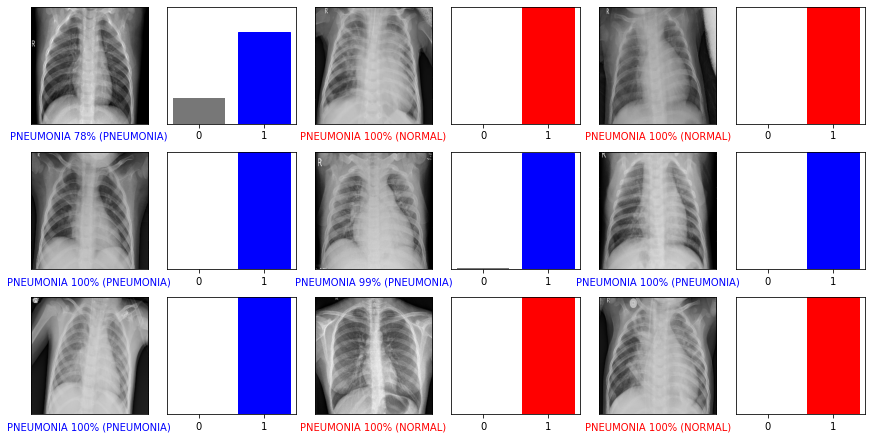

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for images, labels in test_ds.take(1):
  for i in range(9):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_ds)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()